In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.linear_model import Lasso, Ridge

In [2]:
df = pd.read_csv("q5_train.csv")
lmbda = [0.0001]
for i in range(50):
    lmbda.append(lmbda[i]*math.sqrt(3))

In [3]:
def train_ridge(df):
    cols = np.array(df.columns, dtype="str")
    cols = cols[cols != "y"]
    X = df[cols]
    y = df["y"]
    global lmbda
    coefs = []
    const=[]
    for l in lmbda:
        md = Ridge(alpha= l)
        md.fit(X, y)
        coefs.append(md.coef_)
        const.append(md.intercept_)

    coefs = np.stack(coefs, axis=0)
    const = np.array(const).reshape((-1, 1))
    coefs = np.concatenate([coefs, const], axis=1)
    return coefs

def train_lasso(df):
    cols = np.array(df.columns, dtype="str")
    cols = cols[cols != "y"]
    X = df[cols]
    y = df["y"]
    global lmbda
    const=[]
    coefs = []
    for l in lmbda:
        md = Lasso(alpha= l)
        md.fit(X, y)
        coefs.append(md.coef_)
        const.append(md.intercept_)

    coefs = np.stack(coefs, axis=0)
    const = np.array(const).reshape((-1, 1))
    coefs = np.concatenate([coefs, const], axis=1)
    return coefs

In [4]:
def mse(coefs, X, y):
   X2 = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
   diff = ( y.reshape((1, -1)) - coefs @ X2.T )**2
   mse = np.mean(diff, axis=1)
   return mse.reshape((-1, 1))

def r2(coefs, X, y):
   X2 = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
   diff = ((y.reshape((1, -1)))-coefs@X2.T )**2
   ssq = np.sum(diff, axis=1).reshape((-1, 1))
   ym = np.mean(y)
   vary = np.sum((y-ym)**2)
   toret = (1-ssq/vary).reshape((-1, 1))
   return toret

In [5]:
df = pd.read_csv("q5_train.csv")
lmbda = [0.0001]
for i in range(50):
    lmbda.append(lmbda[i]*math.sqrt(3))


In [6]:
df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,y
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,-0.079169,0.074364,0.081928,-0.033283,-0.088749,0.070283,0.285273,0.347548,0.917105
std,0.925317,1.012305,1.304607,1.247467,1.467449,0.969372,1.917598,7.667971,5.020843
min,-2.619745,-2.025143,-4.118158,-3.112832,-4.163859,-2.481295,-4.639841,-40.282934,-10.036450
25%,-0.571875,-0.758508,-0.739871,-0.752772,-0.990666,-0.577054,-1.194308,-0.351381,-2.293765
50%,-0.073228,0.185544,0.095554,-0.063393,-0.030977,-0.047225,0.486986,-0.031732,1.218981
75%,0.382786,0.662315,0.966070,0.755977,0.765230,0.731163,1.666643,0.337055,4.908557
max,2.463242,3.852731,4.339446,3.230194,3.392913,2.515546,5.790406,57.567106,11.343062


In [7]:
filtered_df = df[(df['x8']>-1.5)& (df['x8']<1.5)]

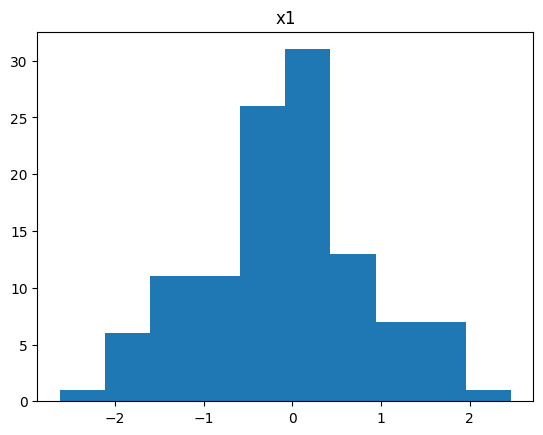

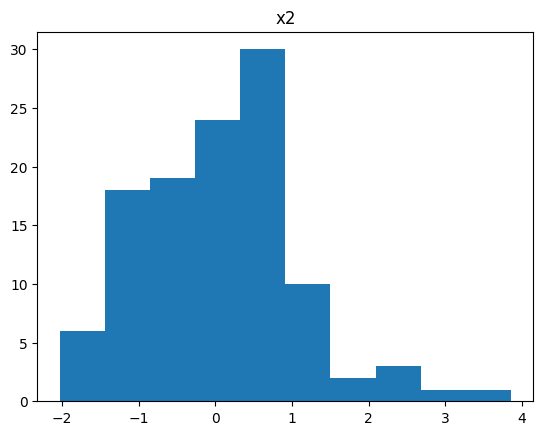

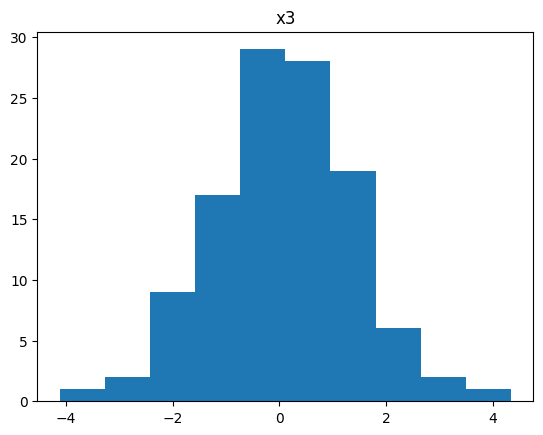

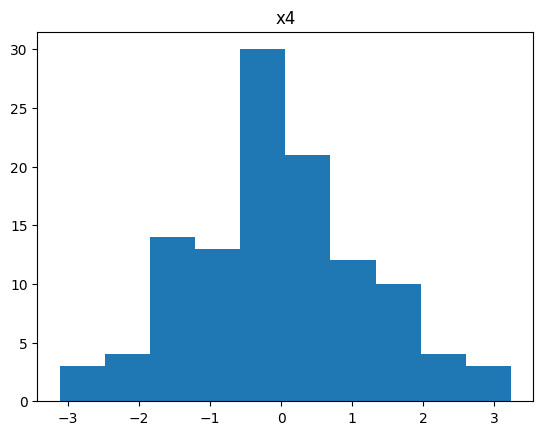

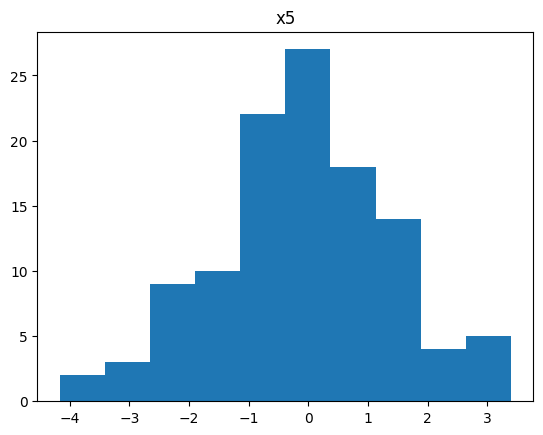

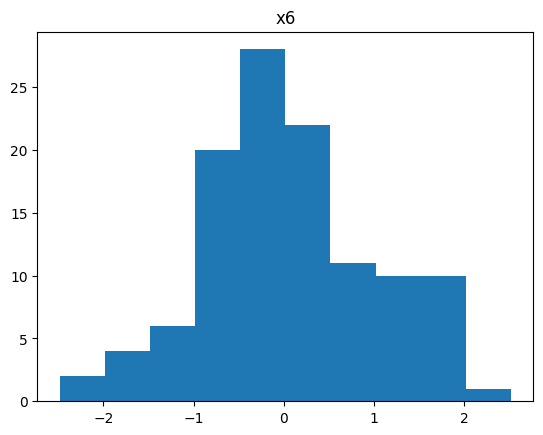

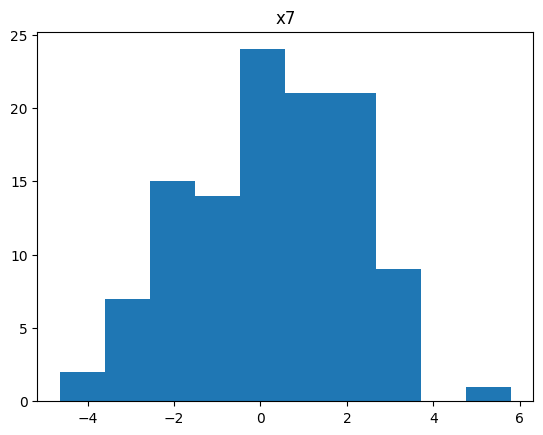

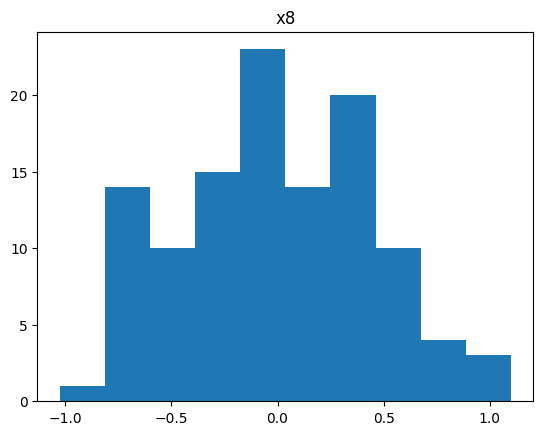

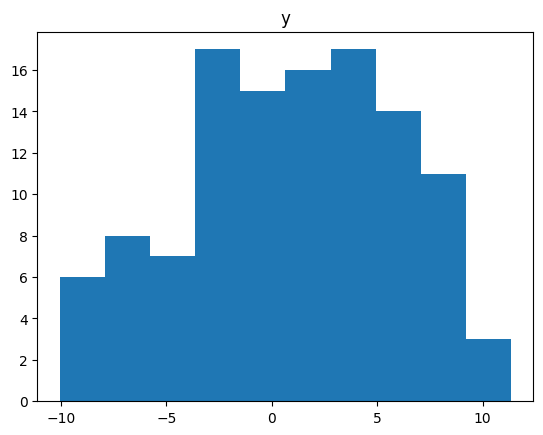

In [11]:
cols = list(filtered_df.columns)
for col in cols:
    plt.figure()
    plt.hist(filtered_df[col])
    plt.title(col)

i will do cv for ridge and lasso to find which leads to better accuracy. 

so for each fold use a scaler, then fit and predict and then find the mse. do this for several trials. 

In [13]:
from sklearn.preprocessing import RobustScaler, StandardScaler


In [20]:
cols = list(df.columns)[:-1]
cols.remove('x6')

In [21]:
cols

['x1', 'x2', 'x3', 'x4', 'x5', 'x7', 'x8']

In [23]:
from sklearn.linear_model import RidgeCV, LassoCV

In [24]:
# cv for find the best scaler
ratio = 0.8
k = 8

# robust scaler
shuff = np.random.permutation(len(filtered_df))
splits = np.array_split(shuff, k)
rs_errs = []
for i in range(k):
    train_inds = np.concatenate(splits[:i]+splits[i+1:], axis=0)
    test_inds = splits[i]
    train = filtered_df.iloc[train_inds]
    test = filtered_df.iloc[test_inds]
    X_train = train[cols]
    y_train = train['y']
    X_test = test[cols]
    y_test = test['y']
    md = LassoCV(alphas=lmbda)
    rs = RobustScaler()
    trans = rs.fit_transform(X_train)
    md.fit(trans, y_train)
    preds = md.predict(rs.transform(X_test))
    rs_errs.append(np.mean(preds-y_test)**2)

In [26]:
rs_errs

[np.float64(1.5389260215659353),
 np.float64(0.26471461430430676),
 np.float64(1.7031923164239051),
 np.float64(1.2868592187355903),
 np.float64(1.4860505340472223),
 np.float64(0.03086486579098127),
 np.float64(0.09621283552508647),
 np.float64(0.3182284769148977)]

In [29]:
print(np.mean(np.array(rs_errs)))

0.8406311104134907


In [27]:
ss_errs = []
for i in range(k):
    train_inds = np.concatenate(splits[:i]+splits[i+1:], axis=0)
    test_inds = splits[i]
    train = filtered_df.iloc[train_inds]
    test = filtered_df.iloc[test_inds]
    X_train = train[cols]
    y_train = train['y']
    X_test = test[cols]
    y_test = test['y']
    md = LassoCV(alphas=lmbda)
    rs = StandardScaler()
    trans = rs.fit_transform(X_train)
    md.fit(trans, y_train)
    preds = md.predict(rs.transform(X_test))
    ss_errs.append(np.mean(preds-y_test)**2)

In [28]:
ss_errs

[np.float64(1.5389557112962262),
 np.float64(0.2647482795373707),
 np.float64(1.6712740217602022),
 np.float64(1.2979970748998282),
 np.float64(1.525450151640411),
 np.float64(0.031786936234031976),
 np.float64(0.09509738636008627),
 np.float64(0.31948079149355013)]

In [30]:
print(np.mean(np.array(ss_errs)))

0.8430987941527133


Conclusion is that scalers dont really matter that much in this data. We will use RobustScaler. Next step is to do LassoCV vs RidgeCV. 
I should have cv for every combination but meh. 

In [31]:
# errors when doing ridgeCV vs when doing LassoCV vs OLS
from sklearn.linear_model import LinearRegression
# here is LassoCV

lasso_errs = []
ridge_errs = []
ols_errs = []

for i in range(k):
    train_inds = np.concatenate(splits[:i]+splits[i+1:], axis=0)
    test_inds = splits[i]
    train = filtered_df.iloc[train_inds]
    test = filtered_df.iloc[test_inds]
    X_train = train[cols]
    y_train = train['y']
    X_test = test[cols]
    y_test = test['y']
    md = LassoCV(alphas=lmbda)
    rs = RobustScaler()
    trans = rs.fit_transform(X_train)
    md.fit(trans, y_train)
    preds = md.predict(rs.transform(X_test))
    lasso_errs.append(np.mean(preds-y_test)**2)

for i in range(k):
    train_inds = np.concatenate(splits[:i]+splits[i+1:], axis=0)
    test_inds = splits[i]
    train = filtered_df.iloc[train_inds]
    test = filtered_df.iloc[test_inds]
    X_train = train[cols]
    y_train = train['y']
    X_test = test[cols]
    y_test = test['y']
    md = RidgeCV(alphas=lmbda)
    rs = RobustScaler()
    trans = rs.fit_transform(X_train)
    md.fit(trans, y_train)
    preds = md.predict(rs.transform(X_test))
    ridge_errs.append(np.mean(preds-y_test)**2)

for i in range(k):
    train_inds = np.concatenate(splits[:i]+splits[i+1:], axis=0)
    test_inds = splits[i]
    train = filtered_df.iloc[train_inds]
    test = filtered_df.iloc[test_inds]
    X_train = train[cols]
    y_train = train['y']
    X_test = test[cols]
    y_test = test['y']
    md = LinearRegression()
    rs = RobustScaler()
    trans = rs.fit_transform(X_train)
    md.fit(trans, y_train)
    preds = md.predict(rs.transform(X_test))
    ols_errs.append(np.mean(preds-y_test)**2)



In [36]:
np.std(lasso_errs)

np.float64(0.6765517011850215)

In [37]:
np.std(ridge_errs)

np.float64(0.7571627430659963)

In [38]:
np.std(ols_errs)

np.float64(0.6727195918739044)

no significant difference. I will use lasso CV then because std of error is slightly less. Now to do cv to find out if to use x3 or not. The reason it might be useful to not use x3 is that it is highly correlated with x2, so we dont risk losing information. 

In [39]:
with_x3_errs = []
for i in range(k):
    train_inds = np.concatenate(splits[:i]+splits[i+1:], axis=0)
    test_inds = splits[i]
    train = filtered_df.iloc[train_inds]
    test = filtered_df.iloc[test_inds]
    X_train = train[cols]
    y_train = train['y']
    X_test = test[cols]
    y_test = test['y']
    md = LassoCV(alphas=lmbda)
    rs = RobustScaler()
    trans = rs.fit_transform(X_train)
    md.fit(trans, y_train)
    preds = md.predict(rs.transform(X_test))
    with_x3_errs.append(np.mean(preds-y_test)**2)

In [40]:
cols

['x1', 'x2', 'x3', 'x4', 'x5', 'x7', 'x8']

In [42]:
without_x3_errs = []
cols_wihtout_x3 = ['x1', 'x2', 'x4', 'x5', 'x6', 'x7', 'x8']
for i in range(k):
    train_inds = np.concatenate(splits[:i]+splits[i+1:], axis=0)
    test_inds = splits[i]
    train = filtered_df.iloc[train_inds]
    test = filtered_df.iloc[test_inds]
    X_train = train[cols_wihtout_x3]
    y_train = train['y']
    X_test = test[cols_wihtout_x3]
    y_test = test['y']
    md = LassoCV(alphas=lmbda)
    rs = RobustScaler()
    trans = rs.fit_transform(X_train)
    md.fit(trans, y_train)
    preds = md.predict(rs.transform(X_test))
    without_x3_errs.append(np.mean(preds-y_test)**2)

In [46]:
np.mean(with_x3_errs)

np.float64(0.8406311104134907)

In [45]:
np.mean(without_x3_errs)

np.float64(0.7285417184265093)

In [110]:
df_shuffled = filtered_df.sample(frac=1, random_state=10).reset_index(drop=True)

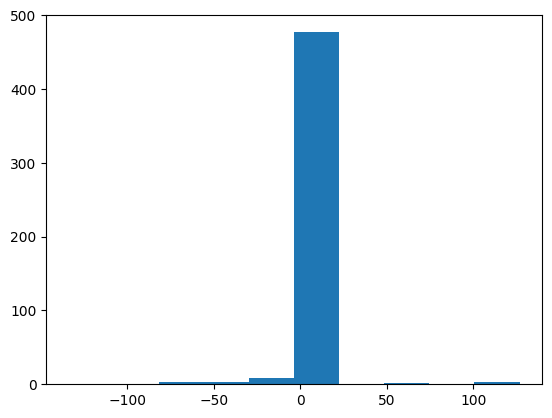

In [111]:
# so train the model and then get the predictions and then try filling bad data with mean of good entries
    
to_pred = pd.read_csv('q5_test.csv')
plt.hist(to_pred['x8'])
smaller_df = to_pred[abs(to_pred['x8'])<1.5]
fill_val = smaller_df['x8'].median()
to_pred['x8'] = np.where(abs(to_pred['x8'])>1.5, fill_val, to_pred['x8'] )


In [112]:

X_train = df_shuffled[cols_wihtout_x3]
y_train = df_shuffled['y']

lc = LassoCV(alphas=lmbda)
rs = RobustScaler()
X_normalized = rs.fit_transform(X_train)
lc.fit(X_normalized, y_train)

y = lc.predict(rs.transform(to_pred[cols_wihtout_x3]))


In [113]:
y

array([ 4.26250250e+00,  6.60244006e+00, -5.25425720e-01,  1.04272855e-01,
       -3.41091775e+00, -4.22836004e+00,  1.40549757e+00, -3.88297439e+00,
       -2.00793409e-01,  2.97061266e+00, -5.34537887e+00, -7.32229100e-01,
        4.42277176e+00,  5.49324028e-01,  2.48212377e+00, -5.17193199e-01,
        3.97205203e+00,  2.07161824e+00, -4.56906805e+00, -2.81240864e+00,
        1.70945434e+00,  5.23562829e+00, -1.33019989e+00, -6.51508549e-02,
        1.48596984e+00,  3.99989074e+00,  1.98064745e+00, -3.19928297e+00,
        7.46243495e-01, -3.56135077e+00,  4.82684631e+00, -3.75197977e+00,
       -3.08088693e+00, -1.68004486e+00,  2.32694609e+00,  7.21607494e-01,
        1.91238330e+00, -6.78158800e+00,  6.33683425e+00, -1.55443720e+00,
        3.40971945e+00, -1.10689940e+00,  3.22075946e+00,  7.18925719e+00,
       -3.29998620e-01,  6.34313501e+00,  6.20809696e-01, -2.03688882e+00,
        8.49147388e-01,  3.04140332e+00,  4.32375580e+00, -2.66455022e+00,
        6.67674591e+00,  

In [114]:
ids = to_pred['Id']

In [115]:
out = pd.DataFrame({
    'Id':ids,
    'y':y
})

In [116]:
out.to_csv('output.csv', index=False)